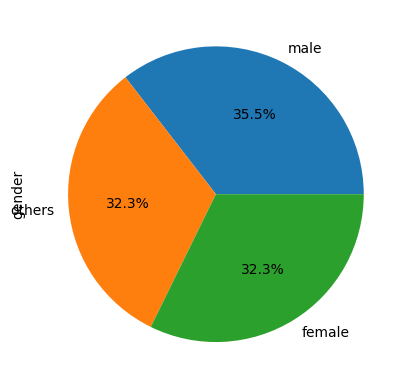

In [16]:
import pandas as pd
import numpy as np
import json
import hashlib
from datetime import datetime, date
import phonenumbers
import matplotlib.pyplot as plt

class DataProcessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.aggregated_data = None

    def read_data(self):
        with open(self.data_path, 'r') as file:
            data = json.load(file)
        self.df = pd.json_normalize(data)
    
    def process_data(self):
        # renaming and selecting the required columns
        self.df = self.df.rename(columns={
            "appointmentId": "appointmentId",
            "phoneNumber": "phoneNumber",
            "patientDetails.firstName": "firstName",
            "patientDetails.lastName": "lastName",
            "patientDetails.gender": "gender",
            "patientDetails.birthDate": "DOB",
            "consultationData.medicines": "medicines"
        })
        self.df["fullName"] = self.df["firstName"] + " " + self.df["lastName"]
        self.df["gender"] = self.df["gender"].map({'M': 'male', 'F': 'female'}).fillna('others')
        
        self.df['isValidMobile'] = self.df['phoneNumber'].apply(self.validate_phone_number)
        self.df['phoneNumberHash'] = self.df['phoneNumber'].apply(self.hash_phone_number)
        self.df['DOB'] = pd.to_datetime(self.df['DOB'], errors='coerce')
        self.df['Age'] = self.df['DOB'].apply(self.calculate_age)
        self.df['noOfMedicines'] = self.df['medicines'].apply(len)
        self.df['noOfActiveMedicines'] = self.df['medicines'].apply(lambda x: sum([med['isActive'] for med in x]))
        self.df['noOfInActiveMedicines'] = self.df['noOfMedicines'] - self.df['noOfActiveMedicines']
        self.df['MedicineNames'] = self.df['medicines'].apply(lambda x: ",".join([med['medicineName'] for med in x if med['isActive']]))

        self.df.to_csv('data.csv', index=False, sep='~')

    def validate_phone_number(self, number):
        try:
            p = phonenumbers.parse(number, 'IN')
            return phonenumbers.is_valid_number(p)
        except:
            return False

    def hash_phone_number(self, number):
        if self.validate_phone_number(number):
            return hashlib.sha256(str(number).encode('utf-8')).hexdigest()
        else:
            return None

    def calculate_age(self, birth_date):
        if pd.isnull(birth_date):
            return None
        else:
            today = date.today()
            return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

    def aggregate_data(self):
        self.aggregated_data = {
            'Age': self.df['Age'].mean(),
            'gender': self.df['gender'].value_counts().to_dict(),
            'validPhoneNumbers': self.df['isValidMobile'].sum(),
            'appointments': self.df['appointmentId'].nunique(),
            'medicines': self.df['noOfMedicines'].sum(),
            'activeMedicines': self.df['noOfActiveMedicines'].sum(),
        }

    def write_aggregated_data(self):
        with open('aggregated.json', 'w') as file:
            json.dump(self.aggregated_data, file, cls=NpEncoder)

    def plot_data(self):
        self.df['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.show()


# Usage:
processor = DataProcessor('data.json')
processor.read_data()
processor.process_data()
processor.aggregate_data()
processor.write_aggregated_data()
processor.plot_data()
